In [6]:
# 🧱 1. Install required libraries
!pip install vaderSentiment
!pip install requests pandas matplotlib seaborn


In [7]:
# 🔐 2. Setup: Twitter API Bearer Token
import requests
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# 👇 Replace this with your actual Bearer Token from Twitter Developer Portal
BEARER_TOKEN = ''


In [8]:
# 📥 3. Fetch Tweets from Twitter API
def fetch_tweets(query, max_results=100):
    headers = {
        'Authorization': f'Bearer {BEARER_TOKEN}',
    }
    url = 'https://api.twitter.com/2/tweets/search/recent'
    params = {
        'query': query,
        'max_results': max_results,
        'tweet.fields': 'id,text,created_at,lang,public_metrics',
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json().get('data', [])
        df = pd.DataFrame(data)
        if df.empty:
            print("⚠️ No tweets found.")
            return pd.DataFrame()
        metrics = df['public_metrics'].apply(pd.Series)
        df = pd.concat([df.drop('public_metrics', axis=1), metrics], axis=1)
        return df
    else:
        print("❌ Error:", response.status_code, response.text)
        return pd.DataFrame()

# Search for Resident Evil 3 Remake
query = '("Resident Evil 3 Remake" OR "RE3 Remake" OR #RE3Remake) lang:en -is:retweet'
tweets_df = fetch_tweets(query)
tweets_df.head()


,lang,created_at,edit_history_tweet_ids,text,id,retweet_count,reply_count,like_count,quote_count,bookmark_count,impression_count
0,en,2025-05-31T08:15:59.000Z,[1928727140771471558],@DynamoSuperX @Supernashbro Re3 og? Yeah 100% ...,1928727140771471558,0,0,0,0,0,8
1,en,2025-05-31T07:59:59.000Z,[1928723114336153964],"@DynamoSuperX Re3 remake wasn't better, if any...",1928723114336153964,0,0,0,0,0,6
2,en,2025-05-31T07:58:16.000Z,[1928722683329454295],@DynamoSuperX OK whoa hold on re3 remake?? 😭,1928722683329454295,1,2,15,0,1,597
3,en,2025-05-31T07:55:25.000Z,[1928721968578134116],@DynamoSuperX Mate I know you did not put the ...,1928721968578134116,0,0,1,0,0,11
4,en,2025-05-31T06:36:36.000Z,[1928702131642708070],Super Mario Bros 3\nCoD Modern Warfare 3 (2011...,1928702131642708070,0,0,2,0,0,60


In [9]:
# 💬 4. Sentiment Analysis with VADER
def analyze_sentiment(df):
    analyzer = SentimentIntensityAnalyzer()

    def get_sentiment(text):
        score = analyzer.polarity_scores(text)
        compound = score['compound']
        if compound >= 0.05:
            return 'Positive'
        elif compound <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df['sentiment'] = df['text'].apply(get_sentiment)
    return df

tweets_df = analyze_sentiment(tweets_df)
tweets_df.head()


,lang,created_at,edit_history_tweet_ids,text,id,retweet_count,reply_count,like_count,quote_count,bookmark_count,impression_count,sentiment
0,en,2025-05-31T08:15:59.000Z,[1928727140771471558],@DynamoSuperX @Supernashbro Re3 og? Yeah 100% ...,1928727140771471558,0,0,0,0,0,8,Negative
1,en,2025-05-31T07:59:59.000Z,[1928723114336153964],"@DynamoSuperX Re3 remake wasn't better, if any...",1928723114336153964,0,0,0,0,0,6,Negative
2,en,2025-05-31T07:58:16.000Z,[1928722683329454295],@DynamoSuperX OK whoa hold on re3 remake?? 😭,1928722683329454295,1,2,15,0,1,597,Negative
3,en,2025-05-31T07:55:25.000Z,[1928721968578134116],@DynamoSuperX Mate I know you did not put the ...,1928721968578134116,0,0,1,0,0,11,Negative
4,en,2025-05-31T06:36:36.000Z,[1928702131642708070],Super Mario Bros 3\nCoD Modern Warfare 3 (2011...,1928702131642708070,0,0,2,0,0,60,Negative


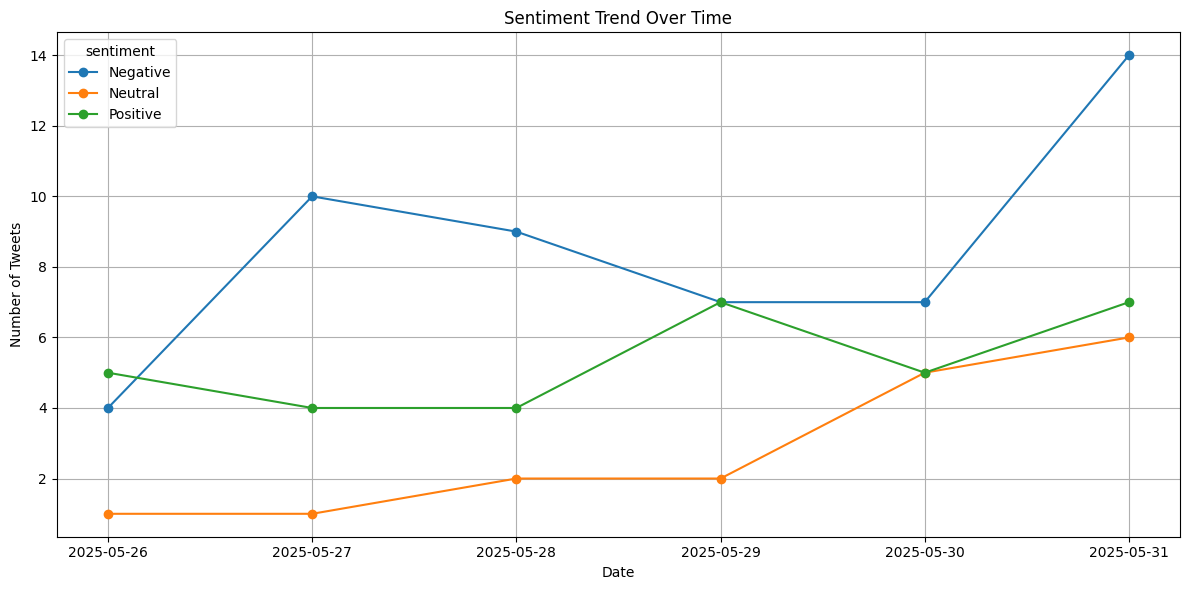

In [10]:
# 📊 5. Visualize Sentiment Over Time
def visualize_trend(df):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date

    trend = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)
    trend.plot(kind='line', figsize=(12, 6), marker='o')
    plt.title("Sentiment Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Tweets")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_trend(tweets_df)
